In [1]:
from IPython.display import Image
from oct2py import octave as oct
from os.path import join
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

def get_matlab_data(directory, filename):
    """
    Imports the matlab scripts generated during execution of
        C codes, and returns an array with the data neccesary
        for analysis of performance
    """
    oct.eval(f"cd {directory}")
    oct.eval(f"{filename}")
    oct.eval(f"save -v7 {filename}.mat")
    data = sio.loadmat(f"{join(directory, filename)}.mat")

    return data['data']

# Week 1

## Introduction
This course is intended for people who is already familiar with linear
algebra concepts, and feels pretty confident about it.The main purpose of the
course is to give some initial background on the development of scientific
computation for **high performance**. All subjects are explained by using
*matrix-matrix* multiplication as example, which is expressed as

$ C := AB + C $

The operation above performs a matrix-matrix multiplication between matrices
`A` and `B`, the result of this multiplication is then added to the matrix
`C`. In english this would be read as "`C` becomes `A` times `B` plus `C`"

### Notation
As in any other course, it is important to define the notation on which all the
future material is going to be based on.

We start defining our three matrices `A` `B` and `C`, of sizes `m x k`, `k x n`
and `m x n` respectively

| Matrix |  size  |
|--------|--------|
|   A    | m x k  |
|   B    | k x n  |
|   C    | m x n  |

Now, each of this matrices can be divided in other forms of sub-structures,
such as rows, columns, and individual entries. A matrix is always written as an
upper case roman letter, whereas rows and columns of the matrix are considered
vectors, and vectors are refered to with lower case roman letters, and last but
not least, individual entries (of matrices or vectors) as well as scalars are
written with the corresponding greek lower case letter.

| Matrix | Vector |  Entry  |
|--------|--------|---------|
|   A    |    a   | $\alpha$|
|   B    |    b   | $\beta$ |
|   C    |    c   | $\gamma$|

An example of the different forms of slicing a matrix, and its corresponding
subentries is given below, with matrix `A` as an example.

$
A = \begin{bmatrix} A \end{bmatrix}
= \begin{bmatrix} a_0 & |  & a_1  & | & ... & | & a_{n - 1} \end{bmatrix}
= \begin{bmatrix} a^{\sim T}_0 \\  --\\a^{\sim T}_1 \\ -- \\ \vdots \\ -- \\ a^{\sim T}_{m - 1}
    \end{bmatrix}
= \begin{bmatrix}
\alpha_{0, 0} & \alpha_{0, 1} & \dots & \alpha_{0, n-1} \\
\alpha_{1, 0} & \alpha_{1, 1} & \dots & \alpha_{1, n-1} \\
\vdots & \vdots & \dots & \vdots \\
\vdots & \vdots & \dots & \vdots \\
\alpha_{m-1, 0} & \alpha_{m-1, 1} & \dots & \alpha_{m-1, n-1}
\end{bmatrix}
$

Another aspect to keep in mind, is that all routines developed during the
course for **matrix-matrix** multiplication, involve `for` loops across the
dimensions of the matrices `A`, `B` and `C`, these are `m`, `n` and `k`.

### Matrix-matrix multiplication
Traditionally, **matrix-matrix** multiplication is taught via dot products of
rows from the matrix on the right, and columns of the matrix on the left. This
is, for a particular entry in matrix `C`, $\gamma_{i, j}$

$
\gamma_{i, j} = \sum_{k = 0}^{p - 1} \alpha_{i, p} \beta_{p, j} + \gamma_{i, j}
$

where `i`, `j` and `p` are *iterators* used to traverse across the matrices in
its corresponding direction, according to the following table

| Dimension | iterator |
|-----------|----------|
|     m     |     i    |
|     k     |     p    |
|     n     |     j    |

An schematic for the structure of **matrix-matrix** multiplication is shown
below

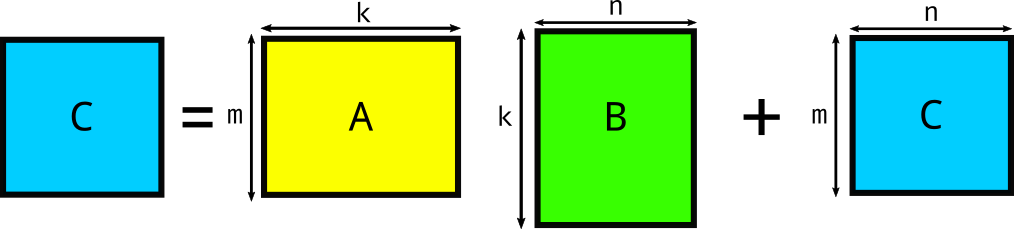

In [2]:
Image(filename="./img/basic_gemm_scheme.png", width=600, height=300)

A typical pseudocode (in *python*) to compute **matrix-matrix** multiplication
according to the dot product formula is as follows

```python
for i in range(m):
    for j in range(n):
        for p in range(k):
            C[i, j] = A[i, p] * B[p, j] + C[i, j]
```

Since the course's codes are written in *C* (remember, High Performance), the
*C* code for the dot product formula is as follows
```C
#define alpha(i, j) A[(j) * ldA + i]   // map alpha(i, j) to array A 
#define beta(i, j)  B[(j) * ldB + i]   // map beta(i, j)  to array B
#define gamma(i, j) C[(j) * ldC + i]   // map gamma(i, j) to array C

void MyGemm(int m, int n, int k, double *A, int ldA,
         double *B, int ldB, double *C, int ldC)
{
    for (int i = 0; i < m; i++)
        for (int j = 0; j < n; j++)
            for (int p = 0; p < k; p++)
            {
                // staff implementation
                gamma(i, j) += alpha(i, p) * beta(p, j);

                // pointer arithmetic implementations
                *(C + i + j * ldC) += *(A + i + p * ldA) * *(B + p + j * ldB);
                C[i + j * ldC] += A[i, p * lda] * B[p, j * ldB];
            }
}
```

The course staff defines some preprocessors that define the elements `alpha`,
`beta` and `gamma` in order to make easier and also more similar to the
mathematical notation, but one can easily spot that this is just *sugar*, and
that under the hood those elements are still accesible with *pointer arithmetic*.

### Performance - Initial Notes
In [/Assignments/Week1/C/Gemm_IJP.c](../Gemm_IJP.c) there
is a simple implementation of the code presented above, which computes $C := AB
+ C$, this will serve as a first approach to show the performance of the
routines that are going to be developed.


In [3]:
directory = join("..", "data")
print(directory)
data = get_matlab_data(directory=directory, filename="output_IJP")

../data
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5
error: graphics_toolkit: gnuplot toolkit is not available
error: called from
    graphics_toolkit at line 81 column 5


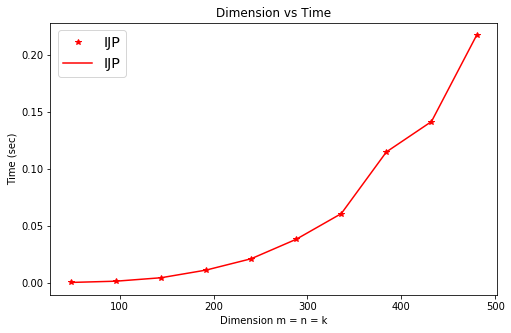

In [16]:
if np.any(np.abs(data[:, 5]) > 1e-10):
    raise Exception("Hmmm, better check if there is an accuracy problem")
    
figsize=[8, 5]

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title("Dimension vs Time")
ax.set_xlabel('Dimension m = n = k')
ax.set_ylabel('Time (sec)')
mean_fig = ax.plot(data[:, 0], data[:, 3], '*r', label="IJP")
mean_fig = ax.plot(data[:, 0], data[:, 3], 'r', label="IJP")
ax.legend(loc="upper left", fontsize="x-large")
plt.show()

From the plot above we can see that the execution time needed to perform
**matrix-matrix** computation is a function of the size of the matrices
involved in the computation (in this case the matrices are square matrices of
equal size, $m = n = k$).

We can tell now that the time execution needed to perform **matrix-matrix**
multiplication grows in some sort of polinomial function $f(n)$, which is
deduced below. From the formula

$
\gamma_{i, j} = \sum_{p = 0}^{k-1} \alpha_{i, p} \beta_{p, j} + \gamma_{i, j}
$

We see that for each element in matrix `C`, we need to, first, perform a
multiplication between one entry of `A` and one of `B`, and then, an addition
of the resulting multiplication to the corresponding entry of `C` is performed,
this is, we perform two floating point operations for `k` times for every entry
`$\gamma$` in matrix `C` (because we perform a dot product with the
corresponding row of `A` and the corresponding column of `B`, both of size
`p`), this is repeated for every entry of `C`, where `C` is size `m x n` which
means we repeat this process for `m x n` entries

$
\#FLOPS = mn \left( 2k \right) = 2mnk
$

Since we are working with square matrices here ($m = n = k$)

$
\#FLOPS = 2m^3
$

To know the ammount of FLOPS needed in a particular computation lets us now
report and analyze the performance of an algorithm in terms of some sort of
rate of computation, which will prove helpful when comparing algorithms and
routines against each other. The rate we are talking about is
$\frac{GFLOPS}{sec}$, which is `GigaFLOPS per second` which tells us how many
floating point operations our algorithm is able to perform.

$
Rate = \frac{2m^3}{t} \times 10^{-9}
$
where:
* m: dimension of matrices
* t: execution time
* $10^{-9}$: convertion to `GigaFLOPS` (since modern cpus can easily perform
gigas of operations per second)


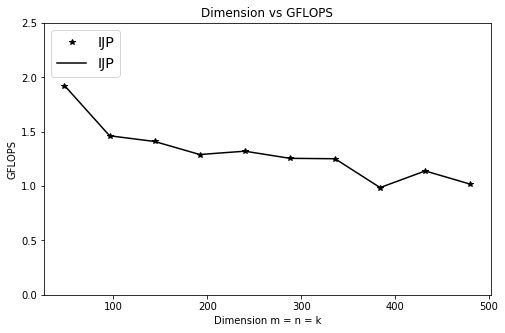

In [15]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title("Dimension vs GFLOPS")
ax.set_xlabel('Dimension m = n = k')
ax.set_ylabel('GFLOPS')
ax.set_ylim(0, 2.5)
mean_fig = ax.plot(data[:, 0], data[:, 4], '*k', label="IJP")
mean_fig = ax.plot(data[:, 0], data[:, 4], 'k', label="IJP")

ax.legend(loc="upper left", fontsize="x-large")
plt.show()